This notebook is primary geared towards looking at the algorithm output.

In particular, since the compute job was stopped due to Cheyenne maintenance, I save intermediate $w$, $c$, and $\lambda$ vectors to `./data/results/00/...`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import stats
from scipy.optimize import minimize

In [2]:
from generate_opt_objects import A_b_generation

In [3]:
# results base directory
BASE_DIR = './data/carbon_flux/results'

# Look at $w$ optimization trajectory

In [16]:
# read in the raw stdout file
with open(BASE_DIR + '/02/stdout.txt', 'r') as f:
    stdout_raw = f.readlines()

In [17]:
# isolate the trajectories from the first w optimization
traj_w = [float(line[22:34].replace('D', 'e')) for line in stdout_raw if 'At iterate' in line][:12]
print(len(traj_w))

12


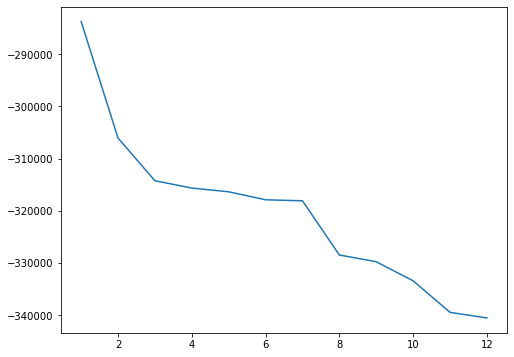

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 13), np.array(traj_w))
plt.show()

In [26]:
# isolate the trajectories from the second w optimization
all_obj_vals = [float(line[22:34].replace('D', 'e')) for line in stdout_raw if 'At iterate' in line]
traj_w_01 = all_obj_vals[:13]
traj_c_01 = all_obj_vals[13:17]
traj_w_02 = all_obj_vals[17:30]
traj_c_02 = all_obj_vals[30:]

print(traj_c_01[0])
print(traj_w_02[0])
print(traj_c_02[0])

406762.0
-274785.0
-532205.0


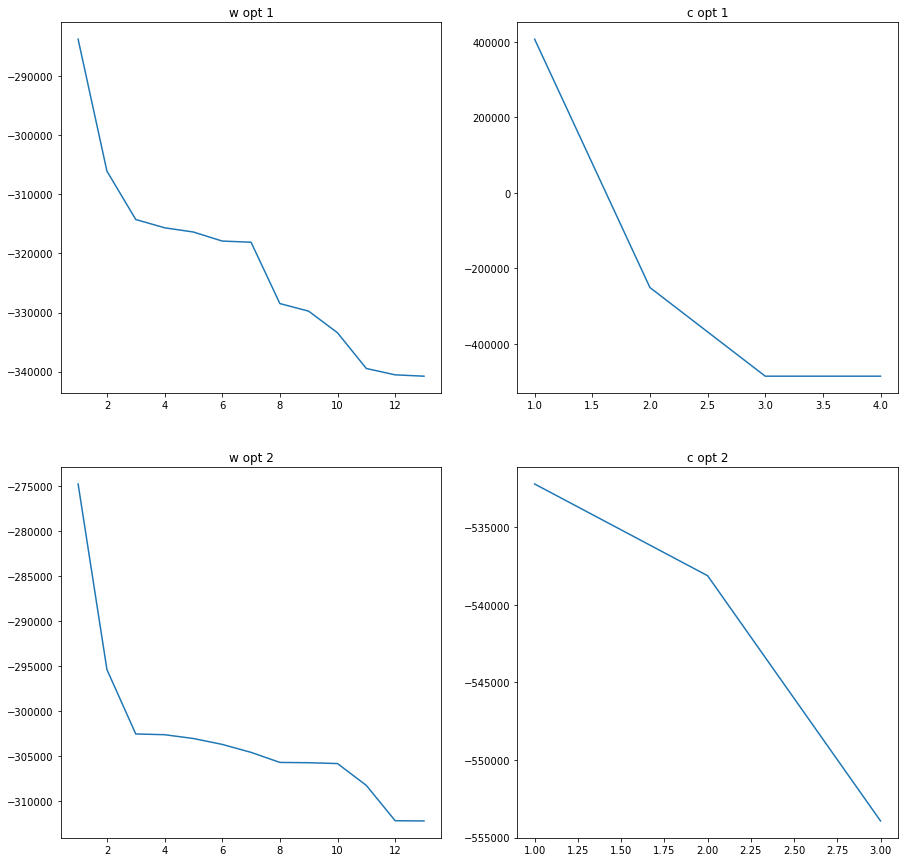

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# plots
ax[0, 0].plot(np.arange(1, 14), traj_w_01)
ax[0, 1].plot(np.arange(1, 5), traj_c_01)
ax[1, 0].plot(np.arange(1, 14), traj_w_02)
ax[1, 1].plot(np.arange(1, 4), traj_c_02)

# titles
ax[0, 0].set_title('w opt 1')
ax[0, 1].set_title('c opt 1')
ax[1, 0].set_title('w opt 2')
ax[1, 1].set_title('c opt 2')

plt.show()

# Feasibility Condition

\begin{equation}
\lVert h + A^T c - K^T w \rVert_2^2
\end{equation}

In [7]:
# import h
with open('./data/carbon_flux/objects/na_june_functional.npy', 'rb') as f:
    h = np.load(f)

# import A
A, b = A_b_generation(
    box_constraint_fp='./data/carbon_flux/objects/scipy_bnds.pkl'
)

print(f'Dim of A: {A.shape}')
print(f'Dim of b: {b.shape}')

Dim of A: (11120, 26496)
Dim of b: (11120,)


#### Starting feasibility

In [8]:
# read in starting points
START_POINT_DIR = './data/carbon_flux/results/02/intermediate_starts/'

with open(START_POINT_DIR + '/cheyenne_stop_w_vec.npy', 'rb') as f:
    w_sp = np.load(f)
with open(START_POINT_DIR + '/cheyenne_stop_c_vec.npy', 'rb') as f:
    c_sp = np.load(f)

In [9]:
# read in K^T w for starting w
with open('../fixed_optimization_inputs/KTw_for_w_start.npy', 'rb') as f:
    KTw_0 = np.load(f)

In [10]:
np.linalg.norm(h + A.T @ c_sp - KTw_0)

16.994936714923163

#### Feasibilitiy after first iteration

In [33]:
# import results dictionary
with open(BASE_DIR + '/02/opt_output_01.pkl', 'rb') as f:
    res_dict = pickle.load(f)
    
print(list(res_dict.keys()))

['objective_evals', 'w_opt_vecs', 'c_opt_vecs', 'lambda_opt_vecs', 'KTw_vecs']


In [36]:
res_dict['objective_evals']

[-28976.74552516779, -33522.524430791666]

In [34]:
# extract plotting objects from results_dict
KTw_vecs = res_dict['KTw_vecs'].copy()
c_vecs = res_dict['c_opt_vecs'].copy()

# look at the norm of the constraint term
num_iters = KTw_vecs.shape[0]
print(f'Number of iterations: {num_iters}')

constr_mat = np.array([
    h + A.T @ c_vecs[i, :] - KTw_vecs[i, :]
    for i in range(num_iters)
])
feasibility = np.sqrt(np.diagonal(constr_mat @ constr_mat.T))

Number of iterations: 10


In [35]:
feasibility

array([10.97259036,  8.17085017,  0.17412791,  0.17412791,  0.17412791,
        0.17412791,  0.17412791,  0.17412791,  0.17412791,  0.17412791])

# Save new starting points

#### For ADMM iteration 2

In [41]:
# isolate the starting vectors
w_start_02 = res_dict['w_opt_vecs'][1, :].copy()
c_start_02 = res_dict['c_opt_vecs'][1, :].copy()
lambda_start_02 = res_dict['lambda_opt_vecs'][1, :].copy()

In [42]:
# output vectors
with open(BASE_DIR + '/02/intermediate_starts/w_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=w_start_02)

with open(BASE_DIR + '/02/intermediate_starts/c_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=c_start_02)

with open(BASE_DIR + '/02/intermediate_starts/lambda_start_it2.npy', 'wb') as f:
    np.save(file=f, arr=lambda_start_02)